## Macromolecular model

This case study follows from the model presented in:

*Omta et al. 2017. Extracting physiological traits from batch and chemostate culture data. L&O*

The equations are below.


\begin{equation} \frac{dC}{dt} = (C_{syn} - E)P \end{equation}
\begin{equation} \frac{dP}{dt} = P_{syn}P \end{equation}
\begin{equation} \frac{dr}{dt} = \frac{1}{\tau}(r_0 - r) \end{equation}
\begin{equation} \frac{dN}{dt} = -\frac{dP}{dt} \end{equation}

\begin{equation} P_{syn} = \mu\left(\frac{N}{N+K}\right) \end{equation}
\begin{equation} r_0 = b\frac{P}{C} \end{equation}
\begin{equation} r_{cell} = \frac{C}{P} \end{equation}
\begin{equation} E = \frac{1}{2}m_{ex}\left(1-\tanh\left(r_{cell} - r_{ex}\right)\right) \end{equation}

In [2]:
library(rstan)
library(lattice)
options(mc.cores = parallel::detectCores())

In [3]:
mod_code <- "functions {
  real[] macro(real   t,           // time
               real[] x,           // state x[1]:CH  x[2]:PR, x[3]:Chl , x[4]:N
               real[] theta,
               real[] x_r,
               int[]  x_i) {       // parameters

    real CNpro = theta[1]; 
    real KN    = theta[2];    
    real mu    = theta[3]; 
    real CHsyn = theta[4]; 
    real m_ex  = theta[5];  
    real R_ex  = theta[6];  
    real tau   = theta[7];
    real b     = theta[8];

    real PRsynth = theta[3]*x[4]/(theta[2]+x[4]);
    real r0      = theta[8]*(x[2]/x[1]);
    real Chl     = x[3]*x[2];
    real Rcell   = x[1]/x[2];
    real excr    = (1/2)*theta[5]*(1-tanh(Rcell - theta[6]));
    
    real dCH    = x[2]*(theta[4] - excr);
    real dr     = (1/theta[7])*(r0-x[3]);
    real dPR    = x[2]*PRsynth;
    real dN     = -dPR/(1+exp(-10000*x[4])); 

    return {dCH,dPR,dr,dN};
  }
}
data {
  int<lower = 0> n;           // num obs
  real t_obs[n];              // obs times
  real<lower = 0> y[n,4];     // observed variable at measurement times
}
parameters {
  real<lower = 0> theta[8];   // parameters
  real<lower = 0> x0[4];      // initial population
  real<lower = 1E-15> sigma[4]; // obs error
}
transformed parameters {
  real x[n,4] = integrate_ode_rk45(macro, x0, -1, t_obs, theta, rep_array(0.0,0), rep_array(0,0), 1e-6, 1e-5, 1e3) ;
  for(i in 1:n){
    x[i,3] = x[i,3]*x[i,2]*1E6;
  }
}
model {
  x0[1]    ~ normal(0.1,1);
  x0[2]    ~ normal(0.1,1);
  x0[3]    ~ normal(10,10);
  x0[4]    ~ normal(0.1,1);  
  theta[1] ~ normal(6.6,10); //prior on CHpro
  theta[2] ~ normal(0.002,3); //prior on KN
  theta[3] ~ normal(0.3,1);
  theta[4] ~ normal(5,10);
  theta[5] ~ normal(10,10);
  theta[6] ~ normal(13,10);
  theta[7] ~ normal(10,10); 
  theta[8] ~ normal(0.05,5); 
  
  for(i in 1:4){
    y[1:n,i] ~ normal(x[1:n,i], sigma[i]);
  }
}"

In [4]:
dat       <- read.csv('../../data/macromolecules.csv')

In [5]:
dat_flynn <- read.csv('../../data/flynn_macromolecules.csv')

In [6]:
dat[,2] <- dat[,2]*0.001                 #PR;
dat[,3] <- dat[,3]*1000                  #Chl;
dat[,4] <- dat[,4]*0.001                 #C
dat     <- merge(dat,dat_flynn[,c(1,4)]) #add environmental nitrogen to the data
dat[,5] <- dat[,5]*0.08325909            #N

In [7]:
head(dat)

t,N,chl,C,ammonium
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.0,0.0185714,15.6689,0.124167,0.10723771
5.5,0.0192857,19.0265,0.178333,0.10490645
6.0,0.0457143,20.1457,0.131667,0.10465668
6.5,0.0257143,45.8875,0.172500,0.10207564
7.0,0.0257143,45.8875,0.170000,0.10207564
7.5,0.0321429,55.9604,0.221667,0.09091893


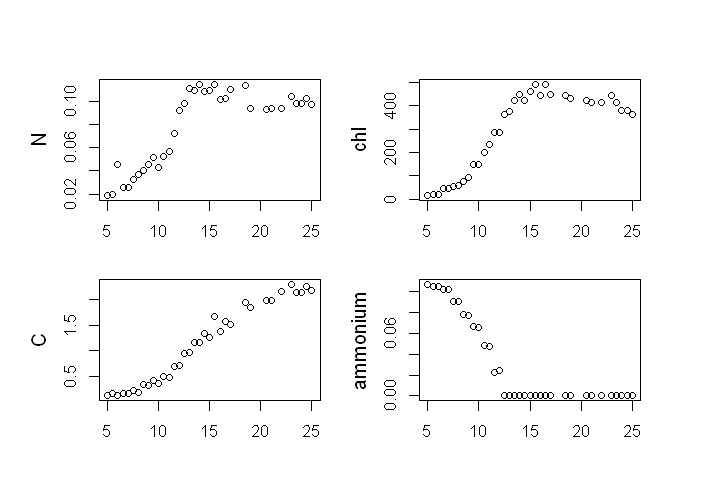

In [8]:
options(repr.plot.width=6, repr.plot.height=4)
par(mfrow=c(2,2),mar=c(2,3,2,2),oma=c(2,2,2,2))
for(i in 2:5){
    plot(dat[,1],dat[,i],ylab='',xlab='')
    mtext(side=2,colnames(dat)[i],line=2.5)
}

In [9]:
data <- list(n    =nrow(dat),
             t_obs=dat[,1],
             y    =dat[,c(4,2,3,5)])

In [10]:
mod <- stan_model(model_code=mod_code)

DIAGNOSTIC(S) FROM PARSER:
Info: integer division implicitly rounds to integer. Found int division: 1 / 2
 Positive values rounded down, negative values rounded up or down in platform-dependent way.



In [11]:
mcmc <- sampling(mod,data=data,iter=2000,chains=4,open_progress=TRUE)

In [12]:
mcmc

Inference for Stan model: df9379b805d3fca48528cc6f7e68e22c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5% n_eff Rhat
theta[1]  11.02    0.11   7.24   0.63   5.41   9.90  15.60  27.20  4584    1
theta[2]   0.02    0.00   0.01   0.01   0.01   0.02   0.03   0.05  1264    1
theta[3]   0.48    0.00   0.09   0.36   0.42   0.47   0.53   0.70  1145    1
theta[4]   1.29    0.00   0.07   1.15   1.24   1.29   1.33   1.42  2024    1
theta[5]  13.04    0.13   8.01   1.04   6.83  12.25  18.26  31.00  3816    1
theta[6]  14.94    0.15   8.34   1.50   8.69  14.29  20.61  33.20  3281    1
theta[7]  11.40    0.04   1.78   8.51  10.15  11.20  12.43  15.34  2359    1
theta[8]   0.05    0.00   0.00   0.04   0.05   0.05   0.05   0.05  2156    1
x0[1]      0.33    0.00   0.06   0.22   0.29   0.33   0.36   0.44  1817    1
x0[2]      0.00    0.00   0.00   0.00   0.00   0.00 

In [20]:
post <- extract(mcmc)

In [40]:
plot_theta <- function(post,theta_names){   #theta_names has to be in the the same order 
	for(i in 1:dim(post$theta)[2]){
		hist(post$theta[,i],main='')
		abline(v=mean(post$theta[,i]),lwd=2)
		mtext(theta_names[i])
	}
}
plot_CV <- function(post,state_names){
	for(i in 1:dim(post$x)[3]){
		hist(post$sigma[,i]/mean(post$x[,,i]),main='')
		mtext(state_names[i])
	}; mtext(outer=TRUE,expression(sigma['x']/mu['x']),line=-1,cex=2)
}
plot_state <- function(post,state_names){
	for(i in 1:dim(post$x)[3]){
		plot(data$t_obs,colMeans(post$x[,,i]),type='l',bty='n')
		lines(data$t_obs,apply(post$x[,,i],2,function(x) quantile(x,probs=0.025)),lty=2)
		lines(data$t_obs,apply(post$x[,,i],2,function(x) quantile(x,probs=0.975)),lty=2)
		points(data$t_obs,data$y[,i])
		mtext(state_names[i])
	}
}	
plot_trace <- function(post,theta_names){
	for(i in 1:dim(post$theta)[2]){
		plot(post$theta[,i],pch=19,cex=0.2)
		abline(h=mean(post$theta[,i]),lwd=2)
		mtext(theta_names[i])
	}
}                           

In [46]:
theta_names <- c('CNpro','KN','mu','CHsyn','m_ex','R_ex','tau','b')
state_names <- c('CH','PR','Chl','N')

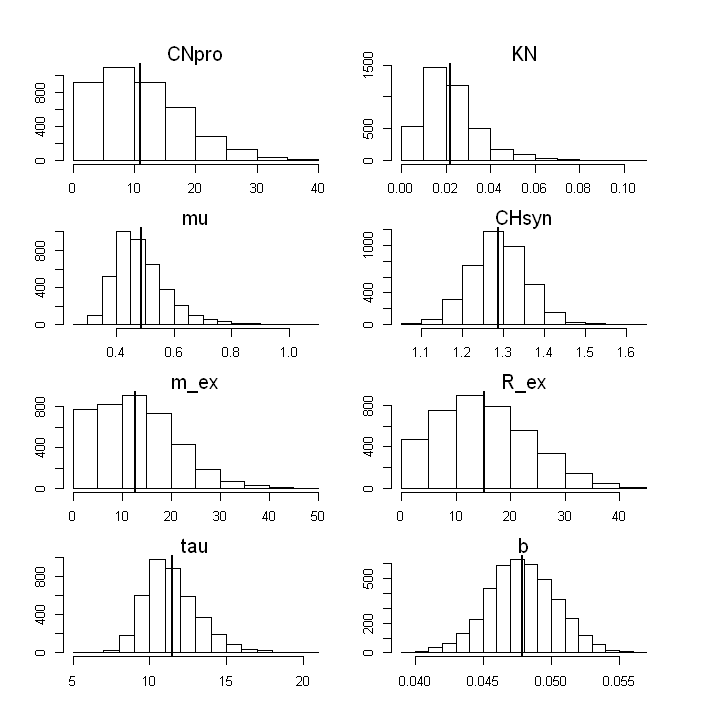

In [47]:
options(repr.plot.width=6, repr.plot.height=6)
par(mfrow=c(4,2),mar=c(2,2,2,2),oma=c(2,2,2,2))
	plot_theta(post=post,theta_names=theta_names)

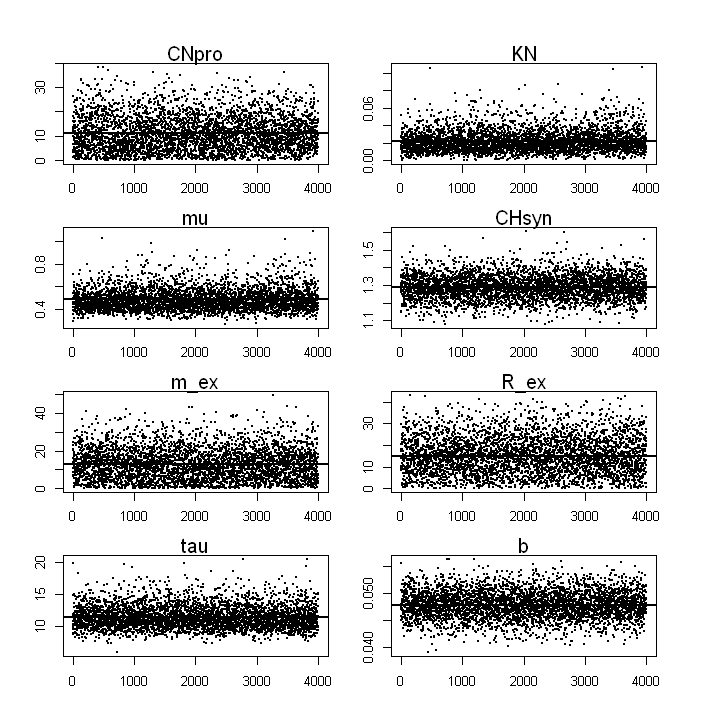

In [48]:
options(repr.plot.width=6, repr.plot.height=6)
par(mfrow=c(4,2),mar=c(2,2,2,2),oma=c(2,2,2,2))
	plot_trace(post=post,theta_names=theta_names)

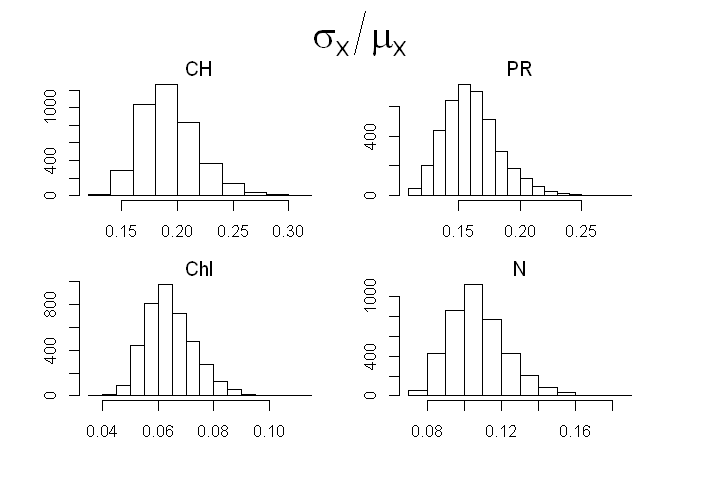

In [49]:
options(repr.plot.width=6, repr.plot.height=4)
par(mfrow=c(2,2),oma=c(2,2,2,2),mar=c(2,2,2,2))
	plot_CV(post=post,state_names=state_names)

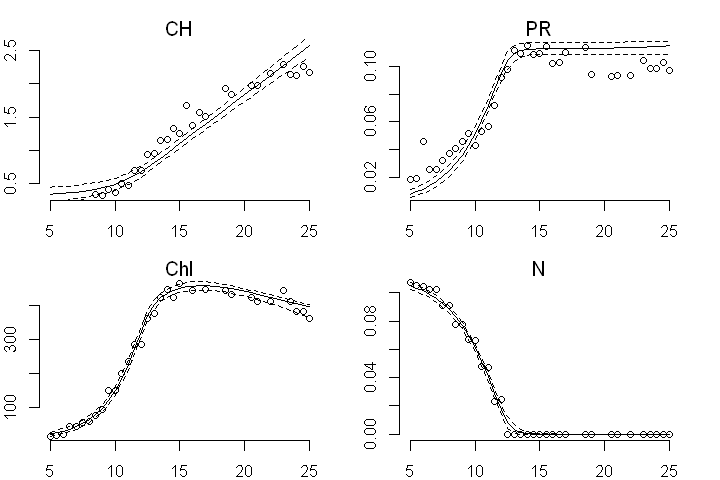

In [50]:
par(mfrow=c(2,2),mar=c(2,2,2,2),mar=c(2,2,2,2))
	plot_state(post=post,state_names=state_names)

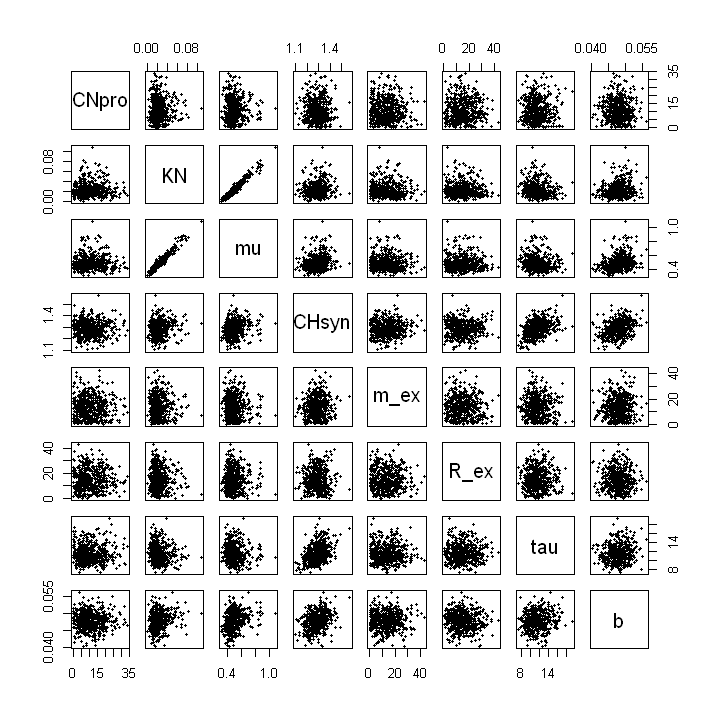

In [71]:
options(repr.plot.width=6, repr.plot.height=6)
pairs(post$theta[sample(1:nrow(post$theta),size=500),],pch=16,cex=0.5,labels=theta_names)